Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import time
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = 'all_data/' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified all_data/notMNIST_large.tar.gz
Found and verified all_data/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

train_filename = data_root + 'notMNIST_large.tar.gz'

test_filename = data_root + 'notMNIST_small.tar.gz'

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

all_data/notMNIST_large already present - Skipping extraction of all_data/notMNIST_large.tar.gz.
['all_data/notMNIST_large\\A', 'all_data/notMNIST_large\\B', 'all_data/notMNIST_large\\C', 'all_data/notMNIST_large\\D', 'all_data/notMNIST_large\\E', 'all_data/notMNIST_large\\F', 'all_data/notMNIST_large\\G', 'all_data/notMNIST_large\\H', 'all_data/notMNIST_large\\I', 'all_data/notMNIST_large\\J']
all_data/notMNIST_small already present - Skipping extraction of all_data/notMNIST_small.tar.gz.
['all_data/notMNIST_small\\A', 'all_data/notMNIST_small\\B', 'all_data/notMNIST_small\\C', 'all_data/notMNIST_small\\D', 'all_data/notMNIST_small\\E', 'all_data/notMNIST_small\\F', 'all_data/notMNIST_small\\G', 'all_data/notMNIST_small\\H', 'all_data/notMNIST_small\\I', 'all_data/notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [6]:
from IPython.display import display, Image

In [4]:
# display(Image(filename=data_root + "notMNIST_small/A/Q0NXaWxkV29yZHMtQm9sZEl0YWxpYy50dGY=.png"))
image_list = os.listdir(test_folders[0])[:5]
print(image_list)
for img in image_list:
    im_path = os.path.join(test_folders[0], img)
    display(Image(filename=im_path))


['MDEtMDEtMDAudHRm.png', 'MDRiXzA4LnR0Zg==.png', 'MjAwcHJvb2Ztb29uc2hpbmUgcmVtaXgudHRm.png', 'MlJlYmVsc0RldXgtQmxhY2sub3Rm.png', 'MlRvb24gU2hhZG93LnR0Zg==.png']


In [6]:
# image_files = os.listdir(test_folders[0])
# print(test_folders[0])
# dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
# print(dataset.shape)
# for image in image_files:
#         image_file = os.path.join(test_folders[0], image)
#         image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
#         print(image_data.shape)
#         dataset[0, :, :] = image_data
#         break
# dataset[0].shape

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' %(num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
          # You may override by setting force=True.
          print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling {0}.'.format(set_filename))
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

all_data/notMNIST_large\A.pickle already present - Skipping pickling.
all_data/notMNIST_large\B.pickle already present - Skipping pickling.
all_data/notMNIST_large\C.pickle already present - Skipping pickling.
all_data/notMNIST_large\D.pickle already present - Skipping pickling.
all_data/notMNIST_large\E.pickle already present - Skipping pickling.
all_data/notMNIST_large\F.pickle already present - Skipping pickling.
all_data/notMNIST_large\G.pickle already present - Skipping pickling.
all_data/notMNIST_large\H.pickle already present - Skipping pickling.
all_data/notMNIST_large\I.pickle already present - Skipping pickling.
all_data/notMNIST_large\J.pickle already present - Skipping pickling.
all_data/notMNIST_small\A.pickle already present - Skipping pickling.
all_data/notMNIST_small\B.pickle already present - Skipping pickling.
all_data/notMNIST_small\C.pickle already present - Skipping pickling.
all_data/notMNIST_small\D.pickle already present - Skipping pickling.
all_data/notMNIST_sm

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

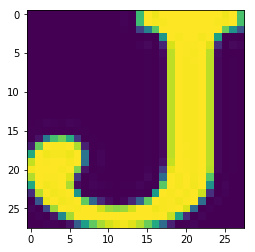

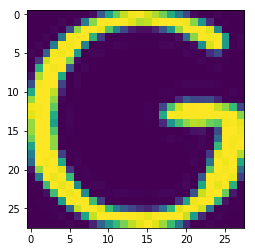

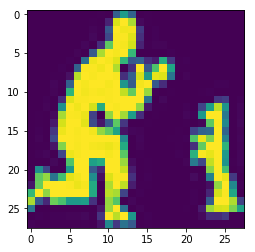

In [9]:
for i in range(3):    
    pickle_file = train_datasets[np.random.randint(10)]  # index 0 should be all As, 1 = all Bs, etc.
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)  # unpickle
        sample_idx = np.random.randint(len(letter_set))  # pick a random image index
        sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
        plt.figure()
        plt.imshow(sample_image)  # display it


---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [10]:
lables_list = ['A', 'B', 'c', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

print("Train")
for i in range(10):    
    pickle_file = train_datasets[i]  # index 0 should be all As, 1 = all Bs, etc.
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)  # unpickle
        print("Num of {0} is {1}".format(lables_list[i], len(letter_set)))
        
print("Test")        
for i in range(10):    
    pickle_file = test_datasets[i]  # index 0 should be all As, 1 = all Bs, etc.
    with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)  # unpickle
        print("Num of {0} is {1}".format(lables_list[i], len(letter_set)))
        

Train
Num of A is 52909
Num of B is 52911
Num of c is 52912
Num of D is 52911
Num of E is 52912
Num of F is 52912
Num of G is 52912
Num of H is 52912
Num of I is 52912
Num of J is 52911
Test
Num of A is 1872
Num of B is 1873
Num of c is 1873
Num of D is 1873
Num of E is 1873
Num of F is 1872
Num of G is 1872
Num of H is 1872
Num of I is 1872
Num of J is 1872


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [11]:
def make_arrays(nb_rows, img_size):
    if nb_rows:
        dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
        labels = np.ndarray(nb_rows, dtype=np.int32)
    else:
        dataset, labels = None, None
    return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
    num_classes = len(pickle_files)
    valid_dataset, valid_labels = make_arrays(valid_size, image_size)
    train_dataset, train_labels = make_arrays(train_size, image_size)
    vsize_per_class = valid_size // num_classes
    tsize_per_class = train_size // num_classes

    start_v, start_t = 0, 0
    end_v, end_t = vsize_per_class, tsize_per_class
    end_l = vsize_per_class+tsize_per_class
    for label, pickle_file in enumerate(pickle_files):       
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)
                if valid_dataset is not None:
                    valid_letter = letter_set[:vsize_per_class, :, :]
                    valid_dataset[start_v:end_v, :, :] = valid_letter
                    valid_labels[start_v:end_v] = label
                    start_v += vsize_per_class
                    end_v += vsize_per_class

                train_letter = letter_set[vsize_per_class:end_l, :, :]
                train_dataset[start_t:end_t, :, :] = train_letter
                train_labels[start_t:end_t] = label
                start_t += tsize_per_class
                end_t += tsize_per_class
        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [12]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [14]:
# count = 1
# for i, img in enumerate(train_dataset):
#     plt.figure()
#     plt.imshow(img)
#     count+=1
#     if count > 10:
#         break

Finally, let's save the data for later reuse:

In [15]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:   
    f = open(pickle_file, 'wb')
    save = {
            'train_dataset': train_dataset,
            'train_labels': train_labels,
            'valid_dataset': valid_dataset,
            'valid_labels': valid_labels,
            'test_dataset': test_dataset,
            'test_labels': test_labels,
            }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [16]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [17]:
dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

print("Examples in train dataset:", len(train_labels) / float(1000), "thousand")
print("Examples in valid dataset:", len(valid_labels) / float(1000), "thousand")
print("Examples in test dataset:", len(test_labels) / float(1000), "thousand")

Examples in train dataset: 200.0 thousand
Examples in valid dataset: 10.0 thousand
Examples in test dataset: 10.0 thousand


##### Clean Datasets
We will check for repetitions within each datasets first. And remove the duplicates.

In [18]:
def are_equal(img1, img2):
    row = img1.shape[0] / 2
    if np.array_equal(img1[row, :], img2[row, :]):
        return np.array_equal(img1, img2)
    else:
        return False

def find_duplicates(labels1, dataset1, labels2=None, dataset2=None):
    classes = np.unique(labels1)
    duplicate_index = []
    try:
        if not labels2:
            for _class in classes:
                num_duplicates = 0
                index = np.where(labels1 == _class)[0]
                combinations = list(it.combinations(range(len(index)), 2))
                print("Comparisons to make for this class:", len(combinations) / float(1000000), "million")
                for i,j in combinations:
                    img1 = dataset1[i]
                    img2 = dataset1[j]
                    if are_equal(img1, img2) == True:
                        duplicate_index.append((i ,j))
                        num_duplicates += 1
                print("The number of matches found in class %d is %d" %(_class, num_duplicates))
            print("Total of matches: %d from a sample size: %d " %(len(duplicate_index), len(labels1)))
    
    except:
        for _class in classes:
            num_duplicates = 0
            index1 = np.where(labels1 == _class)[0]
            index2 = np.where(labels2 == _class)[0]
            print("Comparisons to make for this class:", len(index1) * len(index1) / float(1000000) / 2 , "million\n")
            for i in index1:
                for j in index2:
                    if j >= i:
                        img1 = dataset1[i]
                        img2 = dataset2[j]
                        if are_equal(img1, img2) == True:
                            duplicate_index.append((i ,j))
                            num_duplicates += 1
            print("The number of matches found in class %d is %d" %(_class, num_duplicates))
        print("Total of matches: %d from a sample size: %d \n\n" %(len(duplicate_index), len(labels1)))
    return duplicate_index
         
duplicate_index_valid = find_duplicates(valid_labels, valid_dataset)
duplicate_index_test = find_duplicates(test_labels, test_dataset)
duplicate_index_train = find_duplicates(train_labels, train_dataset)

Comparisons to make for this class: 0.5 million

The number of matches found in class 0 is 0
Comparisons to make for this class: 0.5 million

The number of matches found in class 1 is 0
Comparisons to make for this class: 0.5 million

The number of matches found in class 2 is 0
Comparisons to make for this class: 0.5 million

The number of matches found in class 3 is 0
Comparisons to make for this class: 0.5 million

The number of matches found in class 4 is 0
Comparisons to make for this class: 0.5 million

The number of matches found in class 5 is 0
Comparisons to make for this class: 0.5 million

The number of matches found in class 6 is 0
Comparisons to make for this class: 0.5 million

The number of matches found in class 7 is 0
Comparisons to make for this class: 0.5 million

The number of matches found in class 8 is 0
Comparisons to make for this class: 0.5 million

The number of matches found in class 9 is 0
Total of matches: 0 from a sample size: 10000 


Comparisons to make f

In [20]:
# # view duplicated images
# import random
# def print_images(img1, img2):
#     plt.imshow(np.hstack((img1, img2)), cmap = "gray")
#     plt.axis("off")
#     plt.show()

# index = random.choice(duplicate_index_train)
# print(index)
# print_images(test_dataset[index[0]], test_dataset[index[1]])
# # matches seem to correspond to black images!!

In [21]:
def remove_solid_color_images(dataset):
    rem_index = []
    for i in range(dataset.shape[0]):
        if len(np.unique(dataset[i])) == 1:
            rem_index.append(i)
    return rem_index
    
rem_index_valid = remove_solid_color_images(valid_dataset)
print(rem_index_valid)
# plt.figure()
# plt.imshow(valid_dataset[rem_index_valid[1]]) 
valid_labels = np.delete(valid_labels, rem_index_valid, 0)
valid_dataset = np.delete(valid_dataset, rem_index_valid, 0)

rem_index_test = remove_solid_color_images(test_dataset)
# print(rem_index_test)
test_labels = np.delete(test_labels, rem_index_test, 0)
test_dataset = np.delete(test_dataset, rem_index_test, 0)

rem_index_train = remove_solid_color_images(train_dataset)
# print(rem_index_train)

train_labels = np.delete(train_labels, rem_index_train, 0)
train_dataset = np.delete(train_dataset, rem_index_train, 0)

[100, 223, 356, 382, 542, 694, 784, 843, 983, 1100, 1161, 1228, 1298, 1466, 1537, 1570, 1814, 1878, 2006, 2030, 2120, 2147, 2159, 2323, 2350, 2467, 2507, 2543, 2591, 2768, 2836, 2992, 3478, 3667, 3835, 3852, 4053, 4348, 4349, 4508, 4611, 4717, 4801, 4929, 5054, 5469, 5656, 5701, 5812, 5960, 5961, 6068, 6088, 6199, 6253, 6295, 6471, 6487, 6819, 7075, 7095, 7181, 7203, 7429, 7463, 7531, 7947, 7968, 8212, 8256, 8307, 8468, 8477, 8497, 8562, 8632, 8637, 8690, 8721, 8726, 8814, 8825, 8860, 8951, 8958, 8981, 9134, 9260, 9382, 9466, 9511, 9741, 9988]


In [22]:
def remove_solid_color_images(dataset):
    rem_index = []
    for i in range(dataset.shape[0]):
        if len(np.unique(dataset[i])) == 1:
            rem_index.append(i)
    return rem_index
    
rem_index_valid = remove_solid_color_images(valid_dataset)
valid_labels = np.delete(valid_labels, rem_index_valid, 0)
valid_dataset = np.delete(valid_dataset, rem_index_valid, 0)

rem_index_test = remove_solid_color_images(test_dataset)
test_labels = np.delete(test_labels, rem_index_test, 0)
test_dataset = np.delete(test_dataset, rem_index_test, 0)

rem_index_train = remove_solid_color_images(train_dataset)
train_labels = np.delete(train_labels, rem_index_train, 0)
train_dataset = np.delete(train_dataset, rem_index_train, 0)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [23]:
dic_file = pickle.load(open(pickle_file, 'rb'))
train_dataset = dic_file["train_dataset"]
train_labels = dic_file["train_labels"]
valid_dataset = dic_file["valid_dataset"]
valid_labels = dic_file["valid_labels"]
test_dataset = dic_file["test_dataset"]
test_labels = dic_file["test_labels"]

print("Examples in train dataset:", len(train_labels) / float(1000), "thousand")
print("Examples in valid dataset:", len(valid_labels) / float(1000), "thousand")
print("Examples in test dataset:", len(test_labels) / float(1000), "thousand")

Examples in train dataset: 200.0 thousand
Examples in valid dataset: 10.0 thousand
Examples in test dataset: 10.0 thousand


In [24]:

def train_and_validate(num_examples):
    # flatten datasets
    flat_train = [x.flatten() for x in train_dataset[:num_examples]]
    flat_valid = [x.flatten() for x in valid_dataset[:num_examples]]
#     print(train_labels[:num_examples]) # Check if labels are really shuffled
    model = LogisticRegressionCV().fit(flat_train, train_labels[:num_examples])
    score = cross_val_score(model, flat_valid, valid_labels[:num_examples]).mean()
    return score

In [25]:
training_sizes = [50, 100, 1000, 5000]
print("Cross Validation Score\n")
for size in training_sizes:
    %time score = train_and_validate(size)
    print("Samples:", size,"---> Score:", score)

Cross Validation Score



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The mi

Wall time: 4.44 s
Samples: 50 ---> Score: 0.5486510393631137
Wall time: 5.01 s
Samples: 100 ---> Score: 0.6120809614168247
Wall time: 19.1 s
Samples: 1000 ---> Score: 0.7489003633581947
Wall time: 4min 31s
Samples: 5000 ---> Score: 0.8073988456506509
